In [1]:
from LSTMCell import LSTM
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [2]:
from data_creation import get_trajectories
%load_ext autoreload
%autoreload 2

sol = get_trajectories()

x,y,vx,vy,t = sol

print((x.shape))

(3, 100000)


In [3]:
import numpy as np


# Applied sigmoid but does not seem to do much
# We can first try without sigmoid


# custom function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# # test
x_sig = sigmoid(x)  
y_sig = sigmoid(y)
vx_sig = sigmoid(vx)
vy_sig = sigmoid(vy)




In [4]:
import numpy as np
import pandas as pd

data = np.vstack((x, y, vx, vy)).T

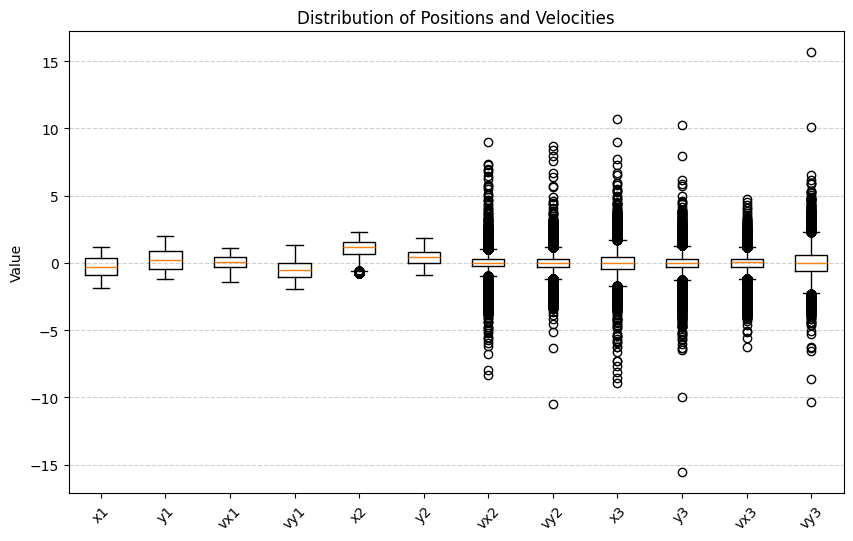

In [5]:
# data visualizations
from data_creation import plot_trajectories, plot_boxplots, plot_velocity_magnitude

plot_boxplots(data)
# plot_velocity_magnitude(data)
# plot_trajectories(data)

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

In [7]:
from data_creation import transform_data
X_train, y_train, X_test, y_test, scaler = transform_data(data, window_size=10, test_size=0.2)



In [ ]:
from LSTMCell import LSTM
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

input_window_size = 12
hidden_size = 32
num_layers = 2

model = LSTM(input_window_size, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses, val_loss = model.training_loop_cv(
    num_epochs = 100, 
    criterion = criterion,
    optimizer = optimizer,
    trainX = X_train,
    trainY = y_train
)

losses_array = np.array(losses)        # shape: (num_folds, num_epochs)
avg_loss = np.mean(losses_array, axis=0)

losses_array = np.array(val_loss)        # shape: (num_folds, num_epochs)
avg_val_loss = np.mean(losses_array, axis=0)

plt.figure(figsize=(8, 5))
plt.plot(avg_loss, color='black', label='Average training Loss')
plt.plot(avg_val_loss, color='blue', label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training Loss Across Folds')
plt.grid(True)
plt.legend()
plt.show()

Fold 1
Epoch [1/100], Train Loss: 0.4863, Val Loss: 0.5401
Epoch [2/100], Train Loss: 0.4767, Val Loss: 0.5332
Epoch [3/100], Train Loss: 0.4662, Val Loss: 0.5252
Epoch [4/100], Train Loss: 0.4519, Val Loss: 0.5147
Epoch [5/100], Train Loss: 0.4274, Val Loss: 0.4986
Epoch [6/100], Train Loss: 0.3813, Val Loss: 0.4730
Epoch [7/100], Train Loss: 0.3246, Val Loss: 0.4486
Epoch [8/100], Train Loss: 0.2839, Val Loss: 0.4280
Epoch [9/100], Train Loss: 0.2513, Val Loss: 0.4083
Epoch [10/100], Train Loss: 0.2227, Val Loss: 0.3903
Epoch [11/100], Train Loss: 0.1991, Val Loss: 0.3741
Epoch [12/100], Train Loss: 0.1802, Val Loss: 0.3600
Epoch [13/100], Train Loss: 0.1654, Val Loss: 0.3475
Epoch [14/100], Train Loss: 0.1532, Val Loss: 0.3360
Epoch [15/100], Train Loss: 0.1426, Val Loss: 0.3254
Epoch [16/100], Train Loss: 0.1334, Val Loss: 0.3157
Epoch [17/100], Train Loss: 0.1255, Val Loss: 0.3071
Epoch [18/100], Train Loss: 0.1185, Val Loss: 0.2993
Epoch [19/100], Train Loss: 0.1123, Val Loss: 0.

Generate time series from 1 input and plot both in one plot

### Save model

In [ ]:
import time

timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"models/model_{timestamp}.pt"

torch.save(model, filename)
print(f"Model saved to {filename}")

### Load model

In [ ]:
import os
model_path = ""

if os.path.exists(model_path):
    print("Loading saved model...")
    model = torch.load(model_path)

In [ ]:
from data_creation import plot_trajectories
steps = 10

sliding_window = 10
generated = X_test[:20]
generated = generated[:, 0, :]

output = model.generate_timeseries(steps=steps, generated=generated, Y_test=y_test, criterion=criterion, sliding_window_size=sliding_window)

# remove middle dimension
X_test_selected = X_test[:, 0, :]

plot_trajectories(X_test_selected[0:steps], output)

### Grid search

In [ ]:
from itertools import product
import torch
import os

# define the grid search parameters
param_grid = {'neurons': [2, 4, 8, 16, 32, 64, 128],
              'optimizer': ['SGD', 'RMSprop', 'Adam'],
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'window_size': [5, 10, 15, 20],
              'hidden_size': [32, 64, 128],
              }


# generate combinations
keys = param_grid.keys()
combinations = [dict(zip(keys, values)) for values in product(*param_grid.values())]
print(f"Total combinations to try: {len(combinations)}")
print(f"If training takes half an hour per combination, this will take {len(combinations)*0.5:.2f} hours, which is {len(combinations)*0.5/24:.2f} days.")

best_val_loss = float('inf')
best_params = None
best_model_state = None

for combo in combinations:
    print(f"Training with combo: {combo}")

    model = LSTM(input_window_size=combo['window_size'],
                 hidden_size=combo['hidden_size'],
                 num_layers=combo['num_layers'])
    
    if combo['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=combo['learning_rate'])
    elif combo['optimizer'] == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=combo['learning_rate'])
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=combo['learning_rate'])
    
    criterion = nn.MSELoss()

    losses, val_loss = model.training_loop_cv(
        num_epochs=10,
        criterion=criterion,
        optimizer=optimizer,
        trainX=X_train,
        trainY=y_train
    )

    final_val_loss = val_loss[-1]
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_params = combo
        best_model_state = model.state_dict()

print(f"Best combo: {best_params} with val loss: {best_val_loss:.4f}")
torch.save(best_model_state, "best_lstm_model.pt")
print("Best model saved to best_lstm_model.pt")